In [1]:
import netCDF4 as nc
import numpy as np
import iris.coords as coords
import cf_units
import iris.cube as icube
import pdb
from scipy.stats import kurtosis
from scipy import stats
import seaborn as sns
import scipy.stats as stats
import random
import matplotlib.pyplot as plt
import math
import numpy.ma as ma
import datetime as dt
import iris.plot as iplt
import matplotlib as mpl
from scipy.stats import chi2
import pandas as pd
import iris
from scipy.stats import gaussian_kde
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from scipy.spatial.distance import mahalanobis, pdist, squareform
from scipy.stats import chi2
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from copulas.multivariate import GaussianMultivariate

# import functions
from FidelityTest import calcDistrStatistic, timeseries_fid_test, plot_fidelity_testing, get_cube_limits, plotStatsMeasures,fidelity_testing_compare
from BiasCorrection import mean_bias_correction, kurtosis_power_transform, ratio_correction,Quantile_mapping,distance_correlation,calculate_correlations,mahalanobis_distance,ks_compare_distributions


In [2]:
# load model data
file_path = '/Users/evayang/Documents/dissertation/data/Hunan_summer_pr_model_DePreSys4.nc'  
model4 = nc.Dataset(file_path, mode='r')

pr_model4 = model4.variables['unknown'][:]
pr_model4.shape
model4.variables.keys()

dict_keys(['unknown', 'leadtime', 'year', 'realisation', 'lat', 'lat_bnds', 'lon', 'lon_bnds', 'month_number', 'month_number_bnds'])

In [3]:
# load model data
file_path = '/Users/evayang/Documents/dissertation/data/Hunan_summer_tas_model_DePreSys4.nc'  
summer_tem_model = nc.Dataset(file_path, mode='r')
summer_tem_model.variables.keys()
tem_model4 = summer_tem_model.variables['tas'][:]
summer_tem_model.variables.keys()

dict_keys(['tas', 'leadtime', 'year', 'realisation', 'height', 'lat', 'lat_bnds', 'lon', 'lon_bnds', 'month_number', 'month_number_bnds'])

In [4]:
def reshape_model(simulations):  
    # reshape model simulations
    n_ensembles = simulations.shape[1]  
    n_months = simulations.shape[2]  
    model = simulations[:].reshape(n_ensembles, -1)
    return model

In [5]:
pr_mod4 = reshape_model(pr_model4)
tem_mod4 = reshape_model(tem_model4)

In [6]:
# load obs data
file_path = '/Users/evayang/Documents/dissertation/data/Hunan_summer_pr_obs_ERA5-Land.nc'  
summer_pr_obs = nc.Dataset(file_path, mode='r')
summer_pr_obs.variables.keys()
pr_obs = summer_pr_obs.variables['tp'][:]
pr_obs.shape

(30,)

In [7]:
# load obs data
file_path = '/Users/evayang/Documents/dissertation/data/Hunan_summer_tas_obs_ERA5-Land.nc'  
summer_tem_obs = nc.Dataset(file_path, mode='r')
summer_tem_obs.variables.keys()
tem_obs = summer_tem_obs.variables['t2m'][:]
tem_obs.shape

(30,)

In [8]:
def reshape_model(simulations):  
    # reshape model simulations
    n_ensembles = simulations.shape[1]  
    n_months = simulations.shape[2]  
    model = simulations[:].reshape(n_ensembles, -1)
    return model

In [9]:
pr_modcor4= ratio_correction(pr_obs, pr_mod4)
tem_modcor4= mean_bias_correction(tem_obs, tem_mod4)


Fidelity testing
calculating distribution statistics
calculating percentiles
Mean perc: 42.25
Standard deviation perc: 54.300000000000004
Skewness perc: 73.82
Kurtosis perc: 5.18
Linear trend perc: 0.09
plotting


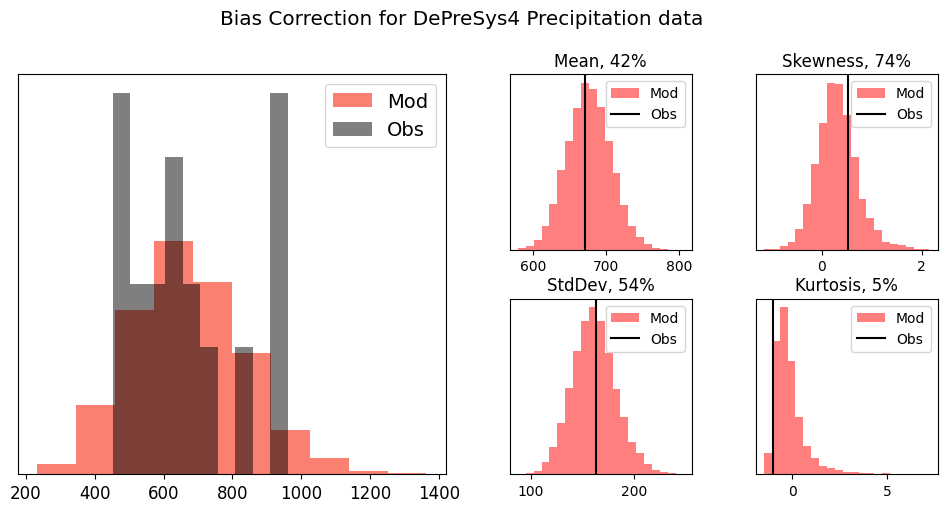

In [10]:
stats_measures_cor4=timeseries_fid_test(pr_obs,pr_modcor4)
plot_fidelity_testing(pr_obs, pr_modcor4, stats_measures_cor4, 0.1,"Bias Correction for DePreSys4 Precipitation data  ","1.png")

In [11]:
obs = np.column_stack((pr_obs, tem_obs))  # (30, 2)
modcor = np.array([pr_modcor4, tem_modcor4])  # (2, 30, 80)
modcor.shape

(2, 30, 100)

## obs/ model/ model_cor combination

In [12]:
# 1. combine obs 
obs_combined = np.column_stack((pr_obs, tem_obs))
print("Combined obs shape:", obs_combined.shape)  

# 2. combine sim
mod_cor = np.empty((30, 100, 2))
mod_cor[:, :, 0] = pr_modcor4
mod_cor[:, :, 1] = tem_modcor4
print("mod_cor shape:", mod_cor.shape) 

mod_raw = np.empty((30, 100, 2))
mod_raw[:, :, 0] = pr_mod4
mod_raw[:, :, 1] = tem_mod4
print("mod_raw shape:", mod_raw.shape)  

# 3. data
print("First few rows of obs_combined:")
print(obs_combined[:5])
print("\nFirst few rows of mod_cor (first ensemble member):")
print(mod_raw[:5, 0, :])
print("\nFirst few rows of mod_cor (first ensemble member):")
print(mod_cor[:5, 0, :])

Combined obs shape: (30, 2)
mod_cor shape: (30, 100, 2)
mod_raw shape: (30, 100, 2)
First few rows of obs_combined:
[[610.75448375  25.46136233]
 [928.35023211  24.91844687]
 [954.39857899  25.33658792]
 [831.77319426  25.72635202]
 [960.43293461  25.33295977]]

First few rows of mod_cor (first ensemble member):
[[565.36144135  25.81407608]
 [519.39445079  28.08564979]
 [556.6325472   27.44481289]
 [870.18886135  25.87066738]
 [680.88897111  25.80912631]]

First few rows of mod_cor (first ensemble member):
[[588.03106971  24.61344269]
 [541.29938165  26.8850164 ]
 [579.15696345  26.2441795 ]
 [897.92953663  24.67003399]
 [705.48049194  24.60849292]]


In [13]:
# 4. statistical info
print("\nObservation statistics:")
print("Mean (pr, tas):", obs_combined.mean(axis=0))
print("Std (pr, tas):", obs_combined.std(axis=0))

print("\nModel statistics:")
print("Mean (pr, tas):", mod_cor.mean(axis=(0, 1)))
print("Std (pr, tas):", mod_cor.std(axis=(0, 1)))

print("\nModel statistics:")
print("Mean (pr, tas):", mod_raw.mean(axis=(0, 1)))
print("Std (pr, tas):", mod_raw.std(axis=(0, 1)))

# 5. correlation
obs_corr = np.corrcoef(obs_combined[:, 0], obs_combined[:, 1])[0, 1]
print("\nObservation correlation between pr and tas:", obs_corr)
mod_corrs = np.array([np.corrcoef(mod_cor[:, i, 0], mod_raw[:, i, 1])[0, 1] for i in range(80)])
print("Model_cor correlation range:", mod_corrs.min(), "to", mod_corrs.max())

mod_rawcor = np.array([np.corrcoef(mod_raw[:, i, 0], mod_raw[:, i, 1])[0, 1] for i in range(80)])
print("Model_raw correlation range:", mod_rawcor.min(), "to", mod_rawcor.max())


Observation statistics:
Mean (pr, tas): [670.68504816  25.85240766]
Std (pr, tas): [163.1468128002196 0.6074457891762629]

Model statistics:
Mean (pr, tas): [670.68504816  25.85240766]
Std (pr, tas): [163.1468128    0.80890722]

Model statistics:
Mean (pr, tas): [646.6629052   27.05304105]
Std (pr, tas): [160.47714763   0.80890722]

Observation correlation between pr and tas: -0.6896029292788531
Model_cor correlation range: -0.5652932315792096 to 0.29479731133281517
Model_raw correlation range: -0.5652932315792094 to 0.2947973113328151


## Correlation between pr_obs and tem_obs

/var/folders/7n/j4hlxg310p57b6kw3wfmm_w80000gn/T/ipykernel_2588/2108444641.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


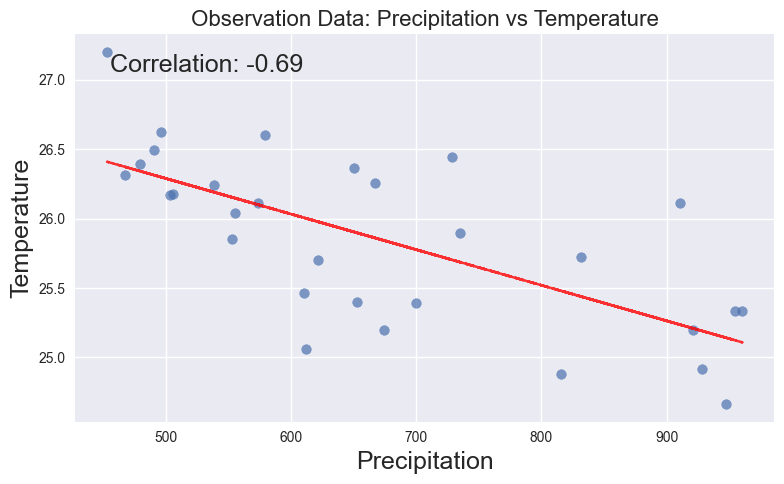

In [14]:
plt.style.use('seaborn')
sns.set_palette("deep")
plt.figure(figsize=(8, 5))
plt.scatter(obs_combined[:, 0], obs_combined[:, 1], alpha=0.7)
plt.title('Observation Data: Precipitation vs Temperature', fontsize=16)
plt.xlabel('Precipitation', fontsize=18)
plt.ylabel('Temperature', fontsize=18)
z = np.polyfit(obs_combined[:, 0], obs_combined[:, 1], 1)
p = np.poly1d(z)
plt.plot(obs_combined[:, 0], p(obs_combined[:, 0]), "r--", alpha=0.8)
corr = np.corrcoef(obs_combined[:, 0], obs_combined[:, 1])[0, 1]
plt.text(0.05, 0.95, f'Correlation: {corr:.2f}', transform=plt.gca().transAxes, 
         fontsize=18, verticalalignment='top')
plt.tight_layout()
plt.show()

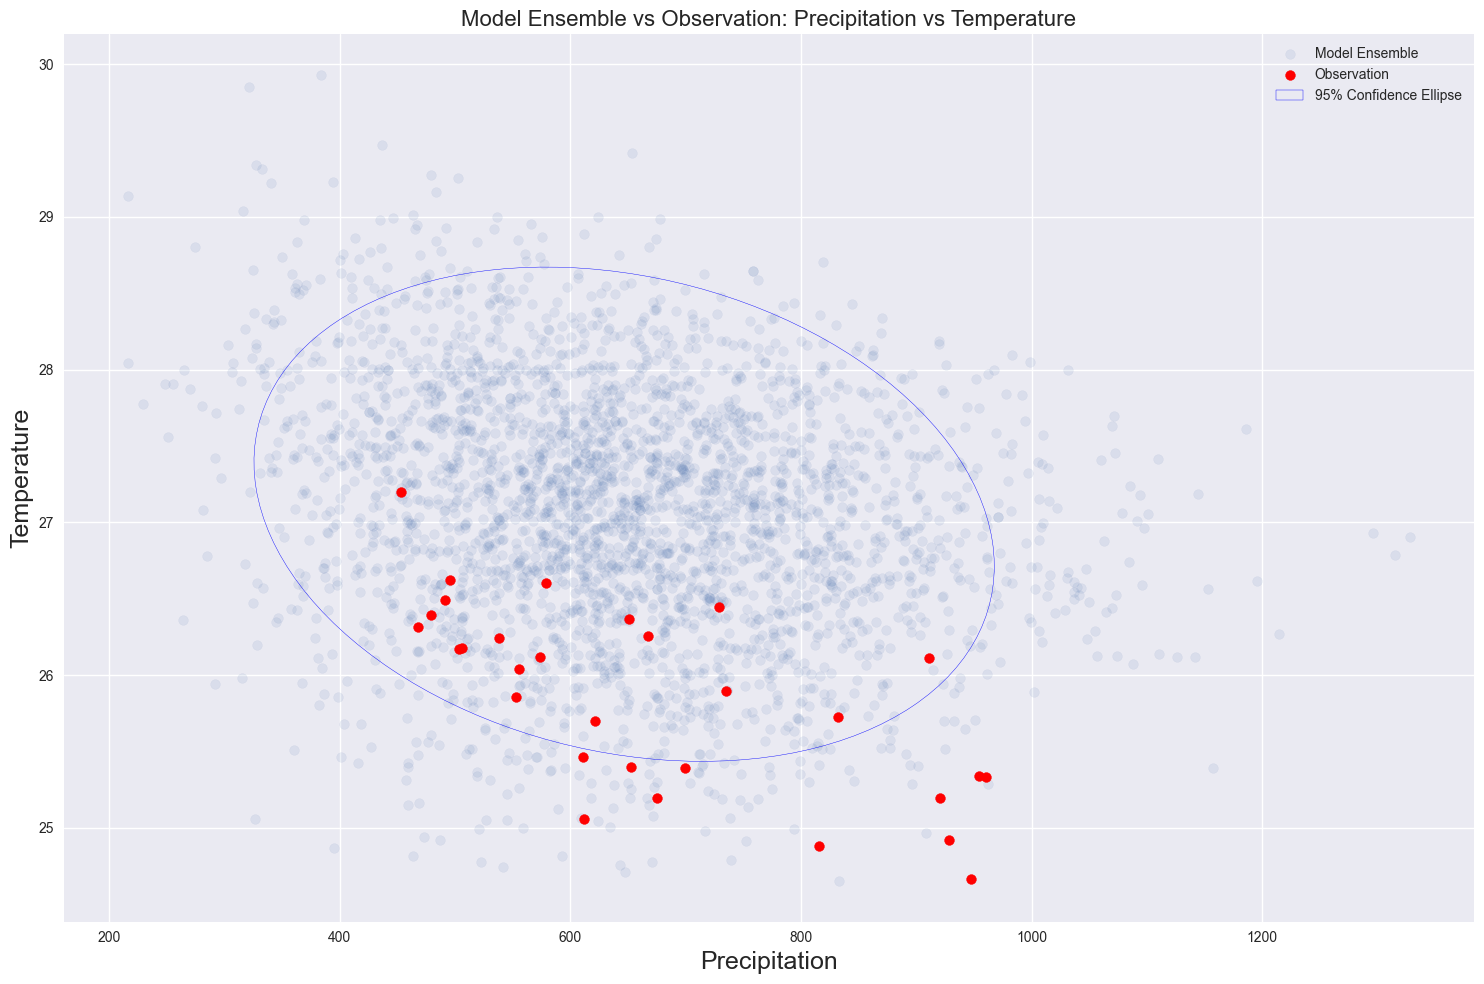

In [15]:

sns.set_palette("deep")

# confidence interval
plt.figure(figsize=(15, 10))
plt.scatter(mod_raw[:,:,0].flatten(), mod_raw[:,:,1].flatten(), 
            alpha=0.1, label='Model Ensemble')
plt.scatter(obs_combined[:,0], obs_combined[:,1], 
            color='red', s=50, label='Observation')
def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)
    scale_x = np.sqrt(cov[0, 0]) * n_std
    scale_y = np.sqrt(cov[1, 1]) * n_std
    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(np.mean(x), np.mean(y))
    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)
confidence_ellipse(mod_raw[:,:,0].flatten(), mod_raw[:,:,1].flatten(), 
                   plt.gca(), n_std=2, edgecolor='blue', label='95% Confidence Ellipse')
plt.title('Model Ensemble vs Observation: Precipitation vs Temperature', fontsize=16)
plt.xlabel('Precipitation', fontsize=18)
plt.ylabel('Temperature', fontsize=18)
plt.legend()
plt.tight_layout()
plt.show()


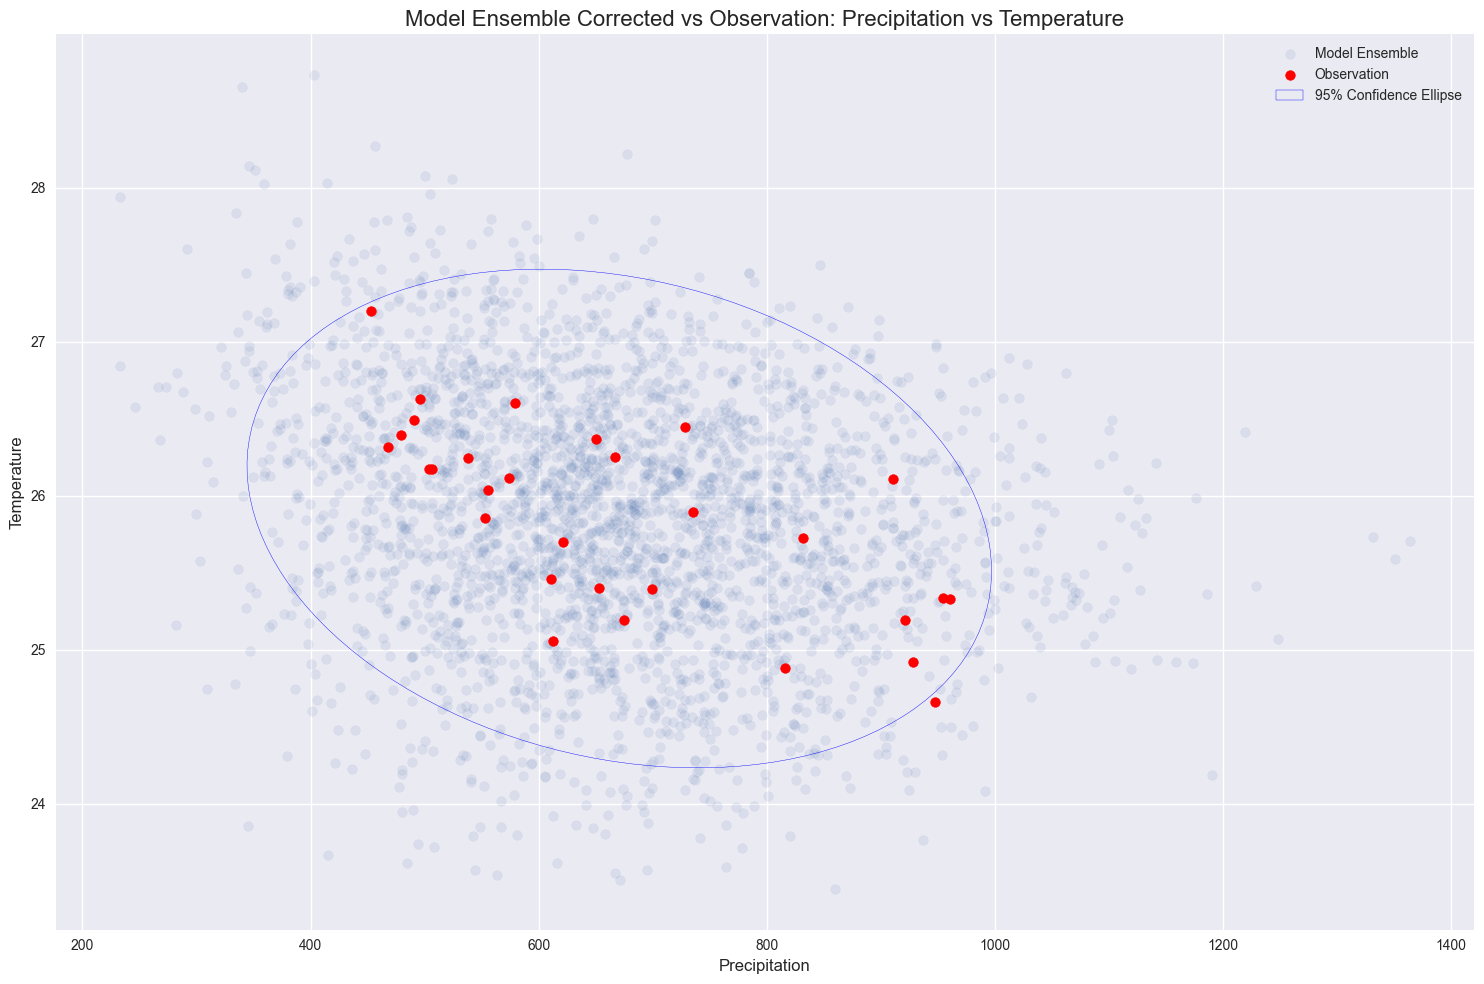

In [16]:

sns.set_palette("deep")

# confidence interval
plt.figure(figsize=(15, 10))
plt.scatter(mod_cor[:,:,0].flatten(), mod_cor[:,:,1].flatten(), 
            alpha=0.1, label='Model Ensemble')
plt.scatter(obs_combined[:,0], obs_combined[:,1], 
            color='red', s=50, label='Observation')
def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)
    scale_x = np.sqrt(cov[0, 0]) * n_std
    scale_y = np.sqrt(cov[1, 1]) * n_std
    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(np.mean(x), np.mean(y))
    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)
confidence_ellipse(mod_cor[:,:,0].flatten(), mod_cor[:,:,1].flatten(), 
                   plt.gca(), n_std=2, edgecolor='blue', label='95% Confidence Ellipse')
plt.title('Model Ensemble Corrected vs Observation: Precipitation vs Temperature', fontsize=16)
plt.xlabel('Precipitation', fontsize=12)
plt.ylabel('Temperature', fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()


/Users/evayang/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:4691: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


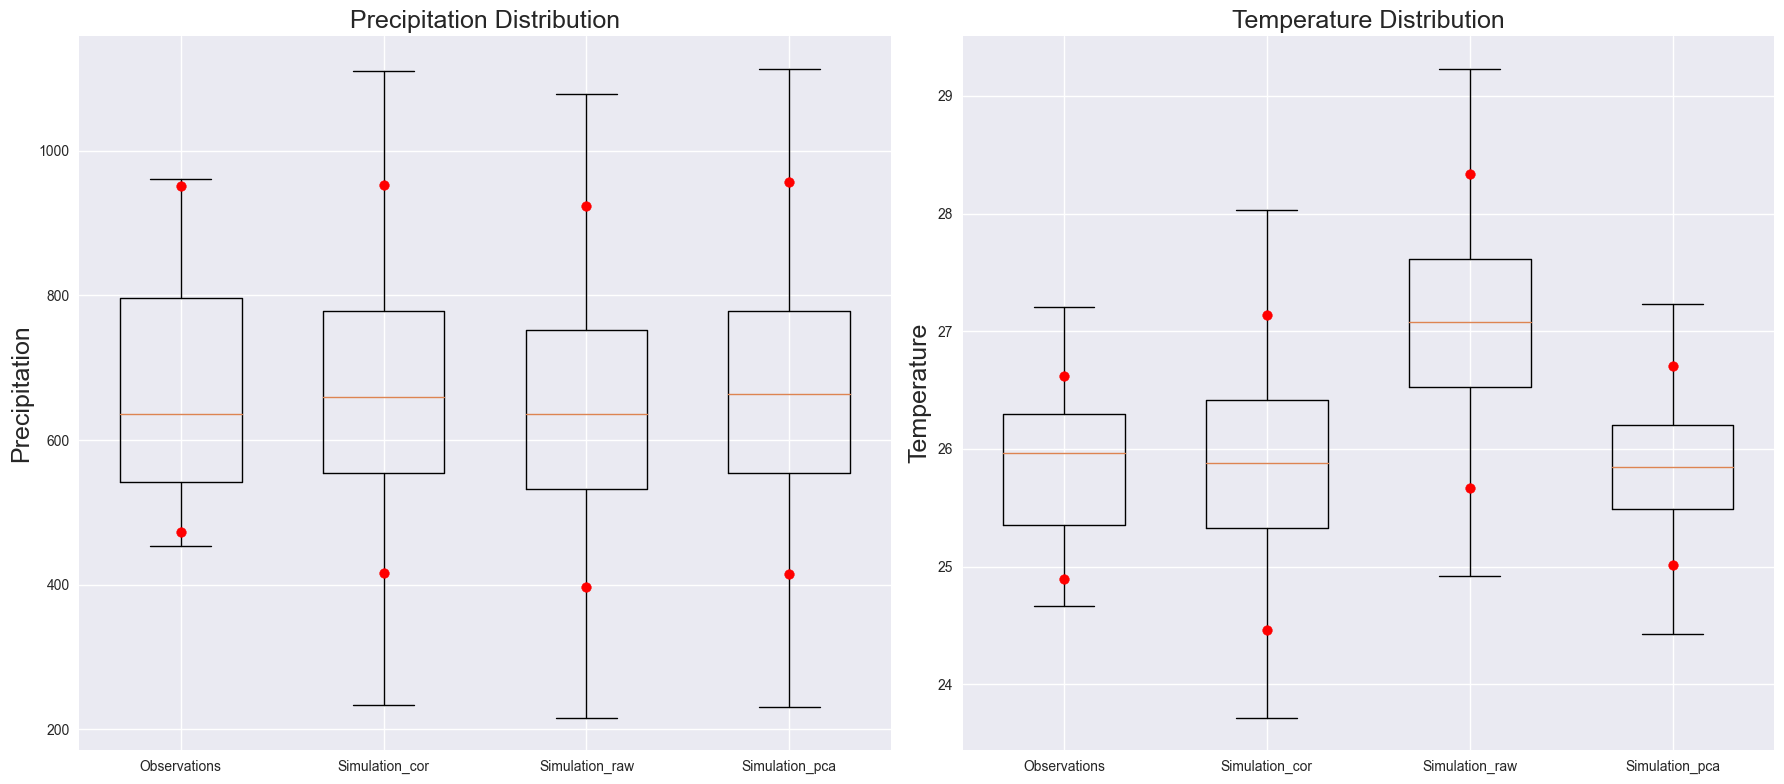

In [48]:
import numpy as np
import matplotlib.pyplot as plt

# 假设你已经有了 obs_combined, mod_cor, mod_raw, 和 mod_pca 数据
# 并且它们的形状是兼容的。

quantiles = [0.05, 0.25, 0.5, 0.75, 0.95]
obs_quantiles = np.quantile(obs_combined, quantiles, axis=0)
mod_quantiles = np.quantile(mod_cor.reshape(-1, 2), quantiles, axis=0)
modraw_quantiles = np.quantile(mod_raw.reshape(-1, 2), quantiles, axis=0)
modpca_quantiles = np.quantile(mod_corrected.reshape(-1, 2), quantiles, axis=0)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# 左图：降水分布
bp1 = ax1.boxplot([obs_combined[:, 0], 
                   mod_cor.reshape(-1, 2)[:, 0], 
                   mod_raw.reshape(-1, 2)[:, 0],
                   mod_corrected.reshape(-1, 2)[:, 0]], 
                  positions=[1, 2, 3, 4], 
                  labels=['Observations', 'Simulation_cor', 'Simulation_raw', 'Simulation_pca'],
                  showfliers=False, widths=0.6)

ax1.set_title('Precipitation Distribution', fontsize=18)
ax1.set_ylabel('Precipitation', fontsize=18)

# 右图：温度分布
bp2 = ax2.boxplot([obs_combined[:, 1], 
                   mod_cor.reshape(-1, 2)[:, 1], 
                   mod_raw.reshape(-1, 2)[:, 1],
                   mod_corrected.reshape(-1, 2)[:, 1]], 
                  positions=[1, 2, 3, 4], 
                  labels=['Observations', 'Simulation_cor', 'Simulation_raw', 'Simulation_pca'],
                  showfliers=False, widths=0.6)

ax2.set_title('Temperature Distribution', fontsize=18)
ax2.set_ylabel('Temperature', fontsize=18)

# 在每个图中绘制观测数据和模拟数据的分位数
for i, bp in enumerate([bp1, bp2]):
    obs_low, obs_high = obs_quantiles[0, i], obs_quantiles[-1, i]
    mod_low, mod_high = mod_quantiles[0, i], mod_quantiles[-1, i]
    modraw_low, modraw_high = modraw_quantiles[0, i], modraw_quantiles[-1, i]
    modpca_low, modpca_high = modpca_quantiles[0, i], modpca_quantiles[-1, i]
    
    ax = ax1 if i == 0 else ax2
    ax.scatter([1, 1, 2, 2, 3, 3, 4, 4], 
               [obs_low, obs_high, mod_low, mod_high, modraw_low, modraw_high, modpca_low, modpca_high], 
               color='red', zorder=3)

# 设置 x 轴的刻度标签
for ax in [ax1, ax2]:
    ax.set_xticks([1, 2, 3, 4])
    ax.set_xticklabels(['Observations', 'Simulation_cor', 'Simulation_raw', 'Simulation_pca'])

plt.tight_layout()
plt.show()


## Mahalanobis distance to check the consistence

/var/folders/7n/j4hlxg310p57b6kw3wfmm_w80000gn/T/ipykernel_2588/2108444641.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


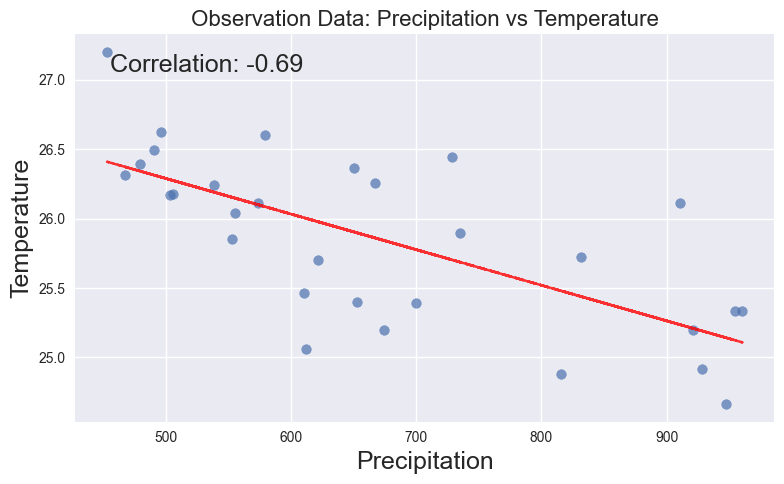

In [20]:
plt.style.use('seaborn')
sns.set_palette("deep")
plt.figure(figsize=(8, 5))
plt.scatter(obs_combined[:, 0], obs_combined[:, 1], alpha=0.7)
plt.title('Observation Data: Precipitation vs Temperature', fontsize=16)
plt.xlabel('Precipitation', fontsize=18)
plt.ylabel('Temperature', fontsize=18)
z = np.polyfit(obs_combined[:, 0], obs_combined[:, 1], 1)
p = np.poly1d(z)
plt.plot(obs_combined[:, 0], p(obs_combined[:, 0]), "r--", alpha=0.8)
corr = np.corrcoef(obs_combined[:, 0], obs_combined[:, 1])[0, 1]
plt.text(0.05, 0.95, f'Correlation: {corr:.2f}', transform=plt.gca().transAxes, 
         fontsize=18, verticalalignment='top')
plt.tight_layout()
plt.show()

## Distance Correlation and Mahalanobis_distance

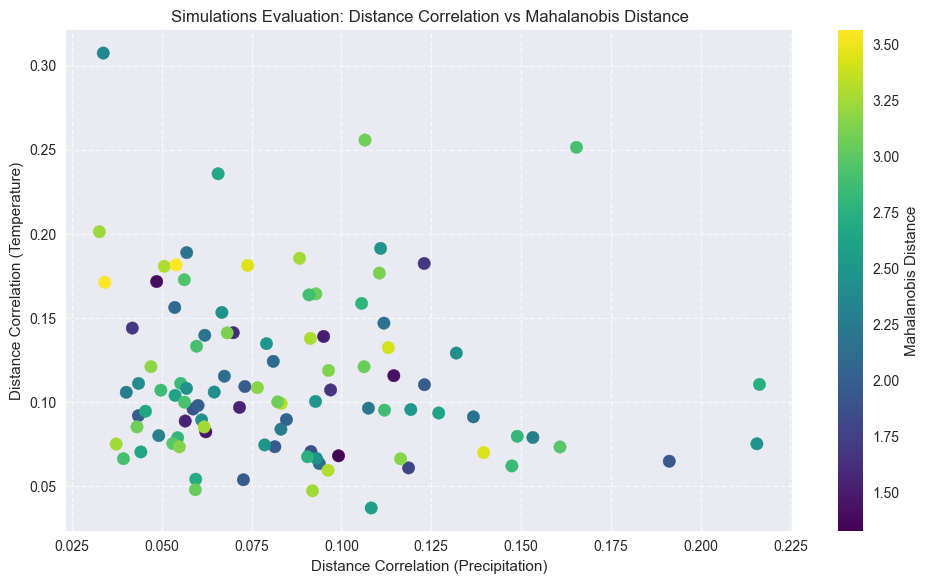

In [50]:
def distance_correlation(X, Y):
    def centering(D):
        mean_D = np.mean(D)
        n = D.shape[0]
        return D - np.mean(D, axis=0) - np.mean(D, axis=1)[:, None] + mean_D

    X = np.atleast_1d(X)
    Y = np.atleast_1d(Y)
    
    if X.shape[0] != Y.shape[0]:
        raise ValueError('X and Y must have the same length')
    
    n = X.shape[0]
    X = X.reshape(n, -1)
    Y = Y.reshape(n, -1)
    X_dist = squareform(pdist(X))
    Y_dist = squareform(pdist(Y))
    X_cent = centering(X_dist)
    Y_cent = centering(Y_dist)
    numerator = np.sum(X_cent * Y_cent)
    denominator = np.sqrt(np.sum(X_cent ** 2) * np.sum(Y_cent ** 2))
    
    if denominator > 0:
        return numerator / denominator
    else:
        return 0

def calculate_correlations(obs, mod):
    correlations = np.zeros((mod.shape[1], 2))
    for i in range(mod.shape[1]):
        correlations[i, 0] = distance_correlation(obs[:, 0], mod[:, i, 0])  # 降水
        correlations[i, 1] = distance_correlation(obs[:, 1], mod[:, i, 1])  # 温度
    return correlations

def mahalanobis_distance(x, data):
    mean = np.mean(data, axis=0)
    cov = np.cov(data.T)
    inv_cov = np.linalg.inv(cov)
    return mahalanobis(x, mean, inv_cov)
# standarlise
scaler = StandardScaler()
obs_combined_scaled = scaler.fit_transform(obs_combined)
mod_raw_scaled = np.zeros_like(mod_raw)
for i in range(mod_raw.shape[1]):
    mod_raw_scaled[:, i, :] = scaler.transform(mod_raw[:, i, :])

# caculate
correlations = calculate_correlations(obs_combined_scaled, mod_raw_scaled)
maha_distances = []
for i in range(mod_raw_scaled.shape[1]):
    maha_dist = mahalanobis_distance(mod_raw_scaled[:, i, :].mean(axis=0), obs_combined_scaled)
    maha_distances.append(maha_dist)

results_df = pd.DataFrame({
    'Model': range(mod_raw.shape[1]),
    'DC_Precipitation': correlations[:, 0],
    'DC_Temperature': correlations[:, 1],
    'Mahalanobis_Distance': maha_distances
})
results_df['Maha_p_value'] = 1 - chi2.cdf(results_df['Mahalanobis_Distance']**2, df=2)
plt.figure(figsize=(10, 6))
scatter = plt.scatter(results_df['DC_Precipitation'], results_df['DC_Temperature'], 
                      c=results_df['Mahalanobis_Distance'], cmap='viridis', s=80)
plt.colorbar(scatter, label='Mahalanobis Distance')
plt.xlabel('Distance Correlation (Precipitation)')
plt.ylabel('Distance Correlation (Temperature)')
plt.title('Simulations Evaluation: Distance Correlation vs Mahalanobis Distance')
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

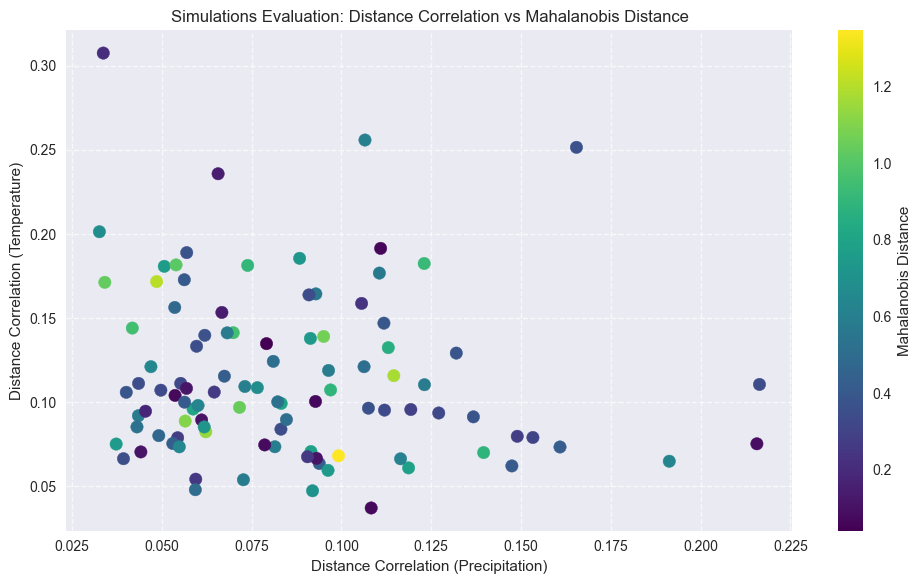

In [51]:
# standarlise
scaler = StandardScaler()
obs_combined_scaled = scaler.fit_transform(obs_combined)
mod_cor_scaled = np.zeros_like(mod_cor)
for i in range(mod_cor.shape[1]):
    mod_cor_scaled[:, i, :] = scaler.transform(mod_cor[:, i, :])
correlations = calculate_correlations(obs_combined_scaled, mod_raw_scaled)
maha_distances = []
for i in range(mod_cor_scaled.shape[1]):
    maha_dist = mahalanobis_distance(mod_cor_scaled[:, i, :].mean(axis=0), obs_combined_scaled)
    maha_distances.append(maha_dist)
results_df = pd.DataFrame({
    'Model': range(mod_cor.shape[1]),
    'DC_Precipitation': correlations[:, 0],
    'DC_Temperature': correlations[:, 1],
    'Mahalanobis_Distance': maha_distances
})
results_df['Maha_p_value'] = 1 - chi2.cdf(results_df['Mahalanobis_Distance']**2, df=2)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(results_df['DC_Precipitation'], results_df['DC_Temperature'], 
                      c=results_df['Mahalanobis_Distance'], cmap='viridis', s=80)
plt.colorbar(scatter, label='Mahalanobis Distance')
plt.xlabel('Distance Correlation (Precipitation)')
plt.ylabel('Distance Correlation (Temperature)')
plt.title('Simulations Evaluation: Distance Correlation vs Mahalanobis Distance')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

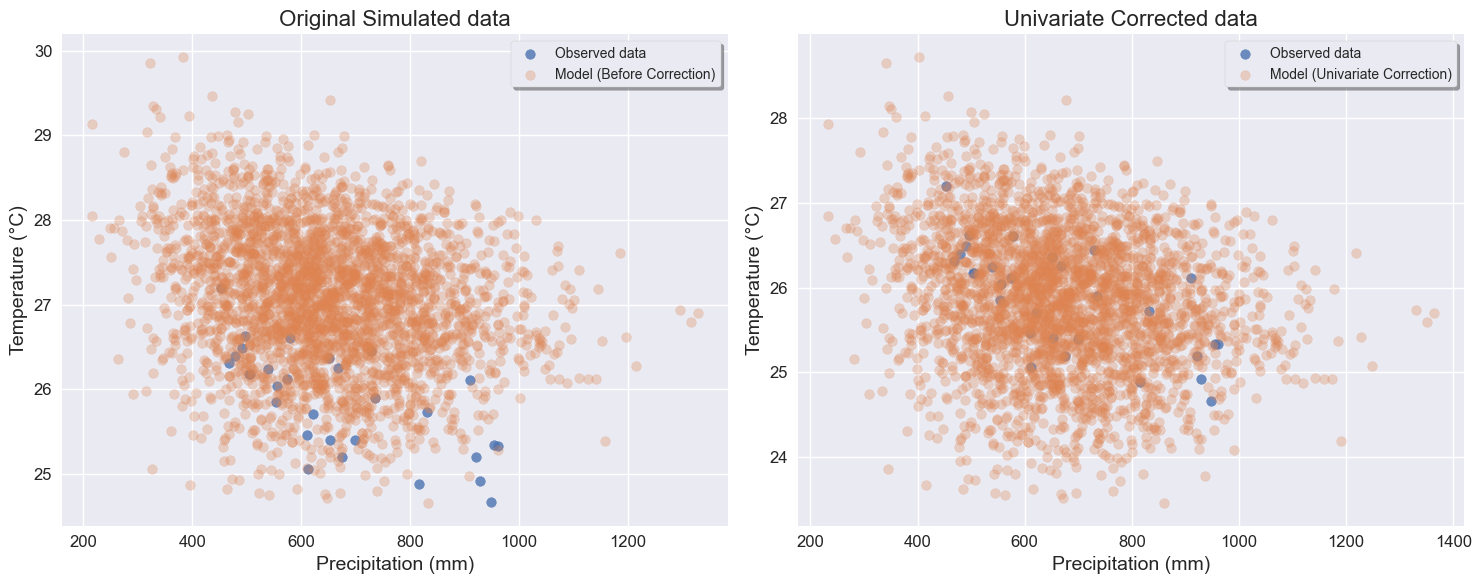

In [53]:
# univariate correction
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
ax1.scatter(obs_combined[:, 0], obs_combined[:, 1], alpha=0.8, label='Observed data')
ax1.scatter(mod_raw[:, :, 0], mod_raw[:, :, 1], alpha=0.3, label='Model (Before Correction)')
ax1.set_title('Original Simulated data', fontsize=16)
ax1.set_xlabel('Precipitation (mm)', fontsize=14)
ax1.set_ylabel('Temperature (°C)', fontsize=14)
ax1.legend(fancybox=True, frameon=True, shadow=True)
ax1.tick_params(axis='both', which='major', labelsize=12)

ax2.scatter(obs_combined[:, 0], obs_combined[:, 1], alpha=0.8, label='Observed data')
ax2.scatter(mod_cor[:, :, 0], mod_cor[:, :, 1], alpha=0.3, label='Model (Univariate Correction)')
ax2.set_title('Univariate Corrected data', fontsize=16)
ax2.set_xlabel('Precipitation (mm)', fontsize=14)
ax2.set_ylabel('Temperature (°C)', fontsize=14)
ax2.legend(fancybox=True, frameon=True, shadow=True)
ax2.tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()
plt.show()


In [27]:
mod_raw[:,:,0].max()

1328.106729703436

In [28]:
def pca_bias_correction(mod, obs):  
    assert mod.shape[0] == obs.shape[0] and mod.shape[2] == obs.shape[1]
    n_years, n_ensembles, n_vars = mod.shape   
    mod_mean = np.mean(mod, axis=1)  # (n_years, n_vars)
    pca = PCA()
    mod_mean_pca = pca.fit_transform(mod_mean)
    obs_pca = pca.transform(obs)
    pca_bias = np.mean(obs_pca, axis=0) - np.mean(mod_mean_pca, axis=0)
    
    mod_corrected = np.zeros_like(mod)
    for i in range(n_ensembles):
        mod_member_pca = pca.transform(mod[:, i, :])
        mod_member_pca_corrected = mod_member_pca + pca_bias
        mod_corrected[:, i, :] = pca.inverse_transform(mod_member_pca_corrected)   
    return mod_corrected
mod_corrected = pca_bias_correction(mod_raw, obs_combined)

print("original shape of simulated data:", mod_raw.shape)
print("corrected shape of simulated data:", mod_corrected.shape)
print("mean of simulated data:", np.mean(mod_raw, axis=(0, 1)))
print("mean of corrected simulated data:", np.mean(mod_corrected, axis=(0, 1)))
print("mean of observed data:", np.mean(obs_combined, axis=0))

original shape of simulated data: (30, 100, 2)
corrected shape of simulated data: (30, 100, 2)
mean of simulated data: [646.6629052   27.05304105]
mean of corrected simulated data: [670.68504816  25.85240766]
mean of observed data: [670.68504816  25.85240766]


In [29]:
mod = mod_raw

In [55]:
def pca_bias_variance_correction_modified(mod, obs):
    assert mod.shape[0] == obs.shape[0] and mod.shape[2] == obs.shape[1] 
    n_years, n_ensembles, n_vars = mod.shape # Reshape mod to 2D for PCA 
    mod_reshaped = mod.reshape(-1, n_vars) 
    pca = PCA() 
    pca.fit(obs) 
    obs_pca = pca.transform(obs) 
    obs_pca_mean = np.mean(obs_pca, axis=0) 
    obs_pca_std = np.std(obs_pca, axis=0) 
    mod_corrected = np.zeros_like(mod) 
    for i in range(n_ensembles): 
        mod_member = mod[:, i, :] 
        mod_member_pca = pca.transform(mod_member) 
        mod_pca_mean = np.mean(mod_member_pca, axis=0) 
        mod_pca_std = np.std(mod_member_pca, axis=0) 
        mod_member_pca_corrected = ((mod_member_pca - mod_pca_mean) / mod_pca_std * obs_pca_std) + obs_pca_mean 
        mod_corrected[:, i, :] = pca.inverse_transform(mod_member_pca_corrected) 
    return mod_corrected 
mod_corrected = pca_bias_variance_correction_modified(mod_raw, obs_combined)

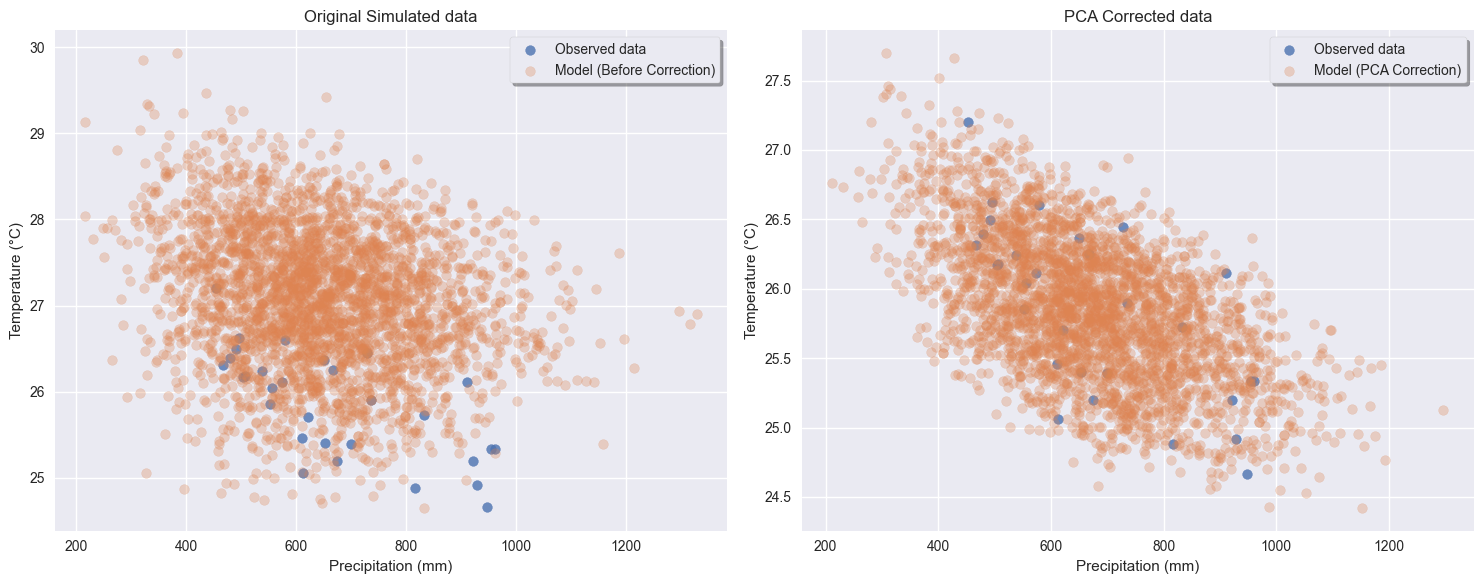

In [56]:
# visualising PCA correction result
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.scatter(obs_combined[:, 0], obs_combined[:, 1], alpha=0.8, label='Observed data')
ax1.scatter(mod_raw[:,:, 0], mod_raw[:, :,1], alpha=0.3, label='Model (Before Correction)')
ax1.set_title('Original Simulated data')
ax1.set_xlabel('Precipitation (mm)')
ax1.set_ylabel('Temperature (°C)')
ax1.legend(fancybox=True, frameon=True, shadow=True)

ax2.scatter(obs_combined[:, 0], obs_combined[:, 1], alpha=0.8, label='Observed data')
ax2.scatter(mod_corrected[:,:, 0], mod_corrected[:,:, 1], alpha=0.3, label='Model (PCA Correction)')
ax2.set_title('PCA Corrected data')
ax2.set_xlabel('Precipitation (mm)')
ax2.set_ylabel('Temperature (°C)')
ax2.legend(fancybox=True, frameon=True, shadow=True)

plt.tight_layout()
plt.show()

In [34]:
def compare_with_svm(obs_data, mod_data):
    X = np.vstack((obs_data, mod_data)) #merge obs and mod data
    y = np.hstack((np.zeros(obs_data.shape[0]), np.ones(mod_data.shape[0]))) #label data 
    scaler = StandardScaler() # standardlised
    X_scaled = scaler.fit_transform(X)    
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)    
    svm_model = svm.SVC(kernel='rbf', probability=True, random_state=42)
    svm_model.fit(X_train, y_train)   
    y_pred = svm_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)    
    y_scores = svm_model.decision_function(X_scaled)
    obs_decision_mean = np.mean(y_scores[:obs_data.shape[0]])
    mod_decision_mean = np.mean(y_scores[obs_data.shape[0]:])    
    fpr, tpr, _ = roc_curve(y, svm_model.predict_proba(X_scaled)[:, 1])
    roc_auc = auc(fpr, tpr)    
    return accuracy, obs_decision_mean, mod_decision_mean, fpr, tpr, roc_auc

Mean Accuracy: 0.5328 ± 0.0923
Mean AUC: 0.6992 ± 0.1515


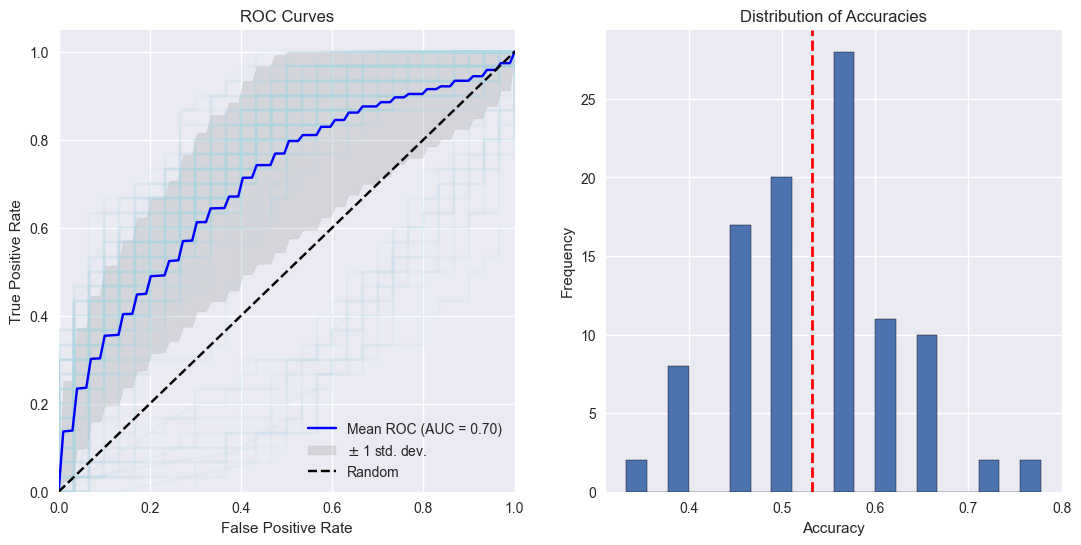

In [35]:
obs_data = obs_combined
num_ensembles = mod_cor.shape[1]

results = [compare_with_svm(obs_data, mod_cor[:, i, :]) for i in range(num_ensembles)]
accuracies, obs_means, mod_means, fprs, tprs, aucs = zip(*results)

plt.figure(figsize=(20, 6))
plt.subplot(131)
mean_fpr = np.linspace(0, 1, 100)
interp_tprs = []
for fpr, tpr in zip(fprs, tprs):
    interp_tprs.append(np.interp(mean_fpr, fpr, tpr))
    interp_tprs[-1][0] = 0.0
    plt.plot(fpr, tpr, color='lightblue', alpha=0.1)
mean_tpr = np.mean(interp_tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_tpr = np.std(interp_tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.plot(mean_fpr, mean_tpr, color='blue',
         label=f'Mean ROC (AUC = {mean_auc:.2f})')
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.2,
                 label=r'$\pm$ 1 std. dev.')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc="lower right")
plt.subplot(132)
plt.hist(accuracies, bins=20, edgecolor='black')
plt.axvline(np.mean(accuracies), color='r', linestyle='dashed', linewidth=2)
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.title('Distribution of Accuracies')

print(f"Mean Accuracy: {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}")
print(f"Mean AUC: {np.mean(aucs):.4f} ± {np.std(aucs):.4f}")

Mean Accuracy: 0.4600 ± 0.0875
Mean AUC: 0.5341 ± 0.1679


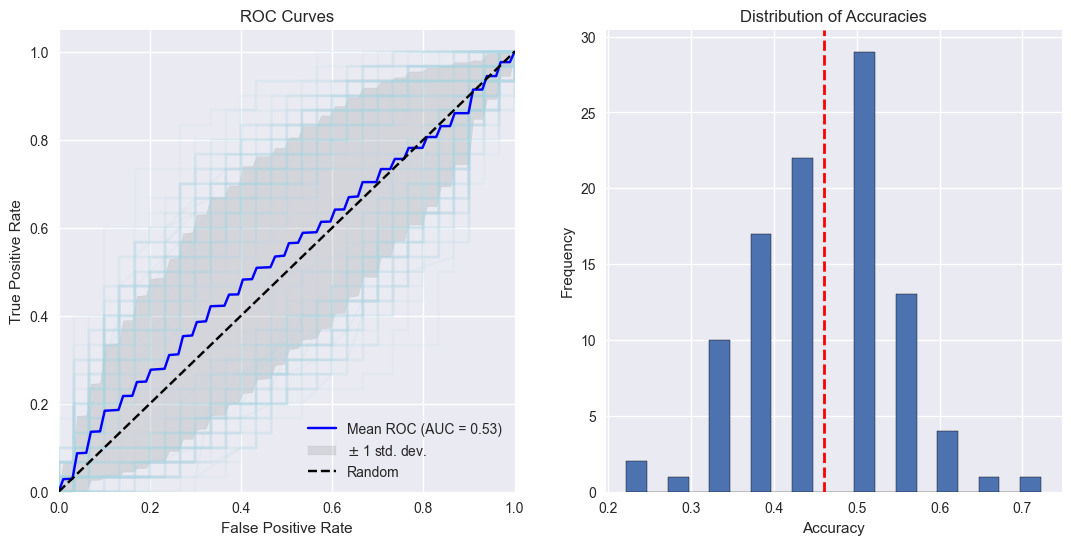

In [36]:
obs_data = obs_combined
num_ensembles = mod_corrected.shape[1]
results = [compare_with_svm(obs_data, mod_corrected[:, i, :]) for i in range(num_ensembles)]
accuracies, obs_means, mod_means, fprs, tprs, aucs = zip(*results)

#ploting:
plt.figure(figsize=(20, 6))
plt.subplot(131)
mean_fpr = np.linspace(0, 1, 100)
interp_tprs = []
for fpr, tpr in zip(fprs, tprs): #roc
    interp_tprs.append(np.interp(mean_fpr, fpr, tpr))
    interp_tprs[-1][0] = 0.0
    plt.plot(fpr, tpr, color='lightblue', alpha=0.1)
mean_tpr = np.mean(interp_tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_tpr = np.std(interp_tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.plot(mean_fpr, mean_tpr, color='blue',
         label=f'Mean ROC (AUC = {mean_auc:.2f})')
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.2,
                 label=r'$\pm$ 1 std. dev.')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc="lower right")
plt.subplot(132)
plt.hist(accuracies, bins=20, edgecolor='black')
plt.axvline(np.mean(accuracies), color='r', linestyle='dashed', linewidth=2)
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.title('Distribution of Accuracies')

print(f"Mean Accuracy: {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}")
print(f"Mean AUC: {np.mean(aucs):.4f} ± {np.std(aucs):.4f}")

Probability of temperature exceeding observed maximum: 4.57%
Probability of temperature below observed minimum: 8.60%
Probability of precipitation exceeding observed maximum: 0.53%
Probability of precipitation below observed minimum: 0.33%
Probability of hot and wet compound extreme: 0.00%
Probability of hot and dry compound extreme: 0.17%
Percentage of simulations with at least one temperature exceeding observed maximum: 96.67%
Percentage of simulations with at least one precipitation exceeding observed maximum: 20.00%


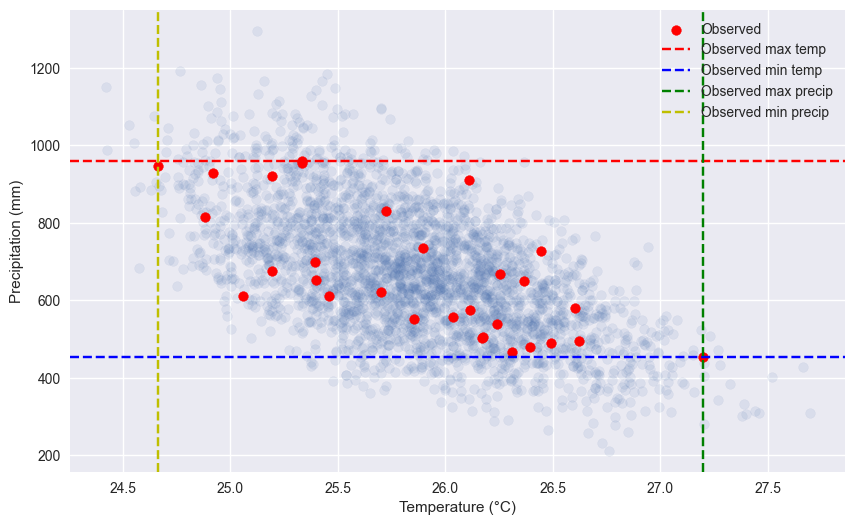

In [37]:
mod = mod_corrected
obs = obs_combined
temp_max = np.max(obs[:, 0])
temp_min = np.min(obs[:, 0])
precip_max = np.max(obs[:, 1])
precip_min = np.min(obs[:, 1])

# Calculate exceedance probabilities
temp_exceed_max = np.mean(mod[:,:,0] > temp_max) * 100
temp_below_min = np.mean(mod[:,:,0] < temp_min) * 100
precip_exceed_max = np.mean(mod[:,:,1] > precip_max) * 100
precip_below_min = np.mean(mod[:,:,1] < precip_min) * 100

print(f"Probability of temperature exceeding observed maximum: {temp_exceed_max:.2f}%")
print(f"Probability of temperature below observed minimum: {temp_below_min:.2f}%")
print(f"Probability of precipitation exceeding observed maximum: {precip_exceed_max:.2f}%")
print(f"Probability of precipitation below observed minimum: {precip_below_min:.2f}%")

# Calculate compound extreme probabilities
hot_wet = np.mean((mod[:,:,0] > temp_max) & (mod[:,:,1] > precip_max)) * 100
hot_dry = np.mean((mod[:,:,0] > temp_max) & (mod[:,:,1] < precip_min)) * 100

print(f"Probability of hot and wet compound extreme: {hot_wet:.2f}%")
print(f"Probability of hot and dry compound extreme: {hot_dry:.2f}%")


plt.figure(figsize=(10, 6))
# Temperature scatter plot
plt.scatter(mod[:,:,1].flatten(), mod[:,:,0].flatten(), alpha=0.1)
plt.scatter(obs[:,1], obs[:,0], color='red', label='Observed')
plt.axhline(temp_max, color='r', linestyle='--', label='Observed max temp')
plt.axhline(temp_min, color='b', linestyle='--', label='Observed min temp')
plt.axvline(precip_max, color='g', linestyle='--', label='Observed max precip')
plt.axvline(precip_min, color='y', linestyle='--', label='Observed min precip')
plt.xlabel('Temperature (°C)')
plt.ylabel('Precipitation (mm)')
#plt.title('Temperature vs Precipitation')
plt.legend()


# 5. Calculate percentage of simulations exceeding observed extremes
temp_exceed_count = np.sum(np.any(mod[:,:,0] > temp_max, axis=1))
precip_exceed_count = np.sum(np.any(mod[:,:,1] > precip_max, axis=1))

print(f"Percentage of simulations with at least one temperature exceeding observed maximum: {temp_exceed_count/30*100:.2f}%")
print(f"Percentage of simulations with at least one precipitation exceeding observed maximum: {precip_exceed_count/30*100:.2f}%")

In [38]:
mod_corrected[:, 1, 1]
#0:temp 1:pr

array([26.19142738, 25.31315416, 25.71876806, 25.73209601, 26.84479236,
       25.97637872, 25.57616756, 26.24373203, 26.05131251, 25.53701601,
       26.68214791, 26.15214717, 25.19333423, 26.00257229, 26.24529263,
       25.41748989, 26.42576843, 25.952287  , 25.48982197, 26.03920533,
       25.8129374 , 24.91771893, 26.29911715, 25.94438428, 25.71712589,
       26.00715405, 25.65825415, 25.11471752, 26.19710919, 25.11879963])

In [39]:
# define two extreme events
def define_high_extremes(data, percentile=80):
    return np.percentile(data, percentile, axis=0)

def define_low_extremes(data, percentile=20):
    return np.percentile(data, percentile, axis=0)

def identify_compound_extremes(temp, precip, temp_high_threshold, precip_high_threshold,temp_low_threshold, precip_low_threshold):
    high_temp_low_precip = (temp >= temp_high_threshold[1]) & (precip <= precip_low_threshold[0])
    high_temp_high_precip = (temp >= temp_high_threshold[1]) & (precip >= precip_high_threshold[0])
    low_temp_high_precip = (temp <= temp_low_threshold[1]) & (precip >= precip_high_threshold[0])
    low_temp_low_precip = (temp <= temp_low_threshold[1]) & (precip <= precip_low_threshold[0])
    return high_temp_low_precip, high_temp_high_precip,low_temp_high_precip,low_temp_low_precip

In [40]:
obs_high_extremes = define_high_extremes(obs_combined)
obs_low_extremes = define_low_extremes(obs_combined)

/Users/evayang/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:4691: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


In [41]:
def analyze_model_extremes(mod_data, obs_high_extremes,obs_low_extremes):
    model_extremes = []
    for i in range(mod_data.shape[1]): 
        extremes = identify_compound_extremes(mod_data[:, i, 1], mod_data[:, i, 0],
                                              obs_high_extremes, obs_high_extremes,obs_low_extremes,obs_low_extremes)
        model_extremes.append(extremes)
    return model_extremes

model_extremes = analyze_model_extremes(mod_corrected, obs_high_extremes,obs_low_extremes)

In [42]:
def calculate_extreme_probability(model_extremes):
    return np.mean([np.mean(extremes, axis=1) for extremes in model_extremes], axis=0)

extreme_probabilities = calculate_extreme_probability(model_extremes)
extreme_probabilities

array([0.07133333, 0.00033333, 0.05566667, 0.00066667])

Text(0, 0.5, 'Probability')

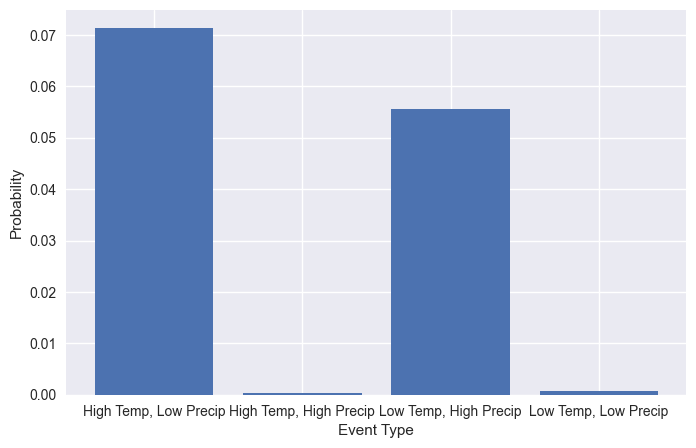

In [57]:
plt.figure(figsize=(8,5))
plt.bar(['High Temp, Low Precip', 'High Temp, High Precip','Low Temp, High Precip','Low Temp, Low Precip'], extreme_probabilities)
#plt.title('Model Predicted Extreme Event Probabilities')
plt.xlabel('Event Type')
plt.ylabel('Probability')

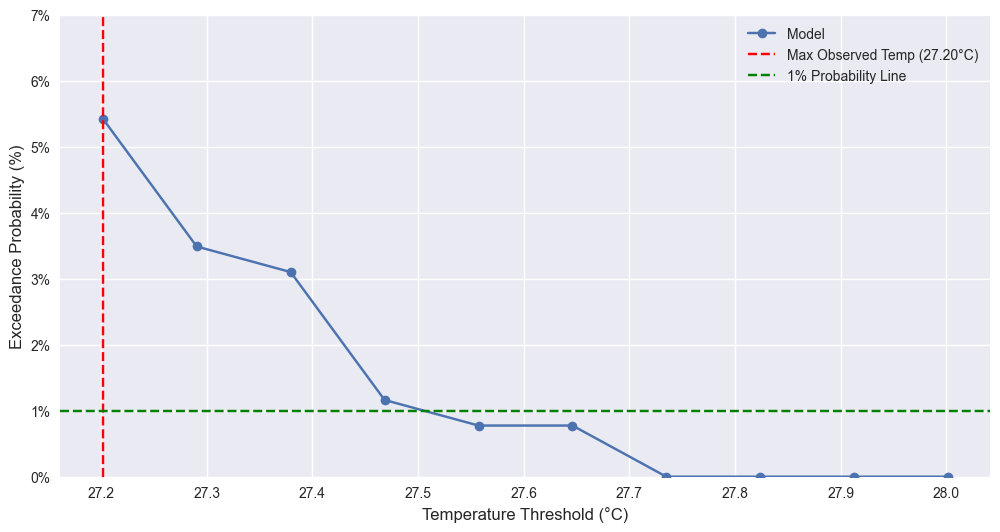

In [44]:
def calculate_conditional_probability(data, condition, thresholds):
    """Calculate conditional probability directly from simulation data"""
    conditional_data = data[data[:, 0] <= condition]
    if len(conditional_data) == 0:
        return [np.nan] * len(thresholds)
    probs = [np.mean(conditional_data[:, 1] > threshold) for threshold in thresholds]
    return probs

# add thresholds and conditions
mod_data = mod_corrected.reshape(-1, 2)
max_temp = np.max(obs_combined[:, 1])
min_temp = np.min(obs_combined[:, 1])  
thresholds = np.linspace(max_temp, max_temp + 0.8, 10)
precipitation_condition = np.min(obs_combined[:, 0])

results = []
for threshold in thresholds:
    conditional_data = mod_data[mod_data[:, 0] <= precipitation_condition]
    if len(conditional_data) == 0:
         prob = np.nan
    else:
         prob = np.mean(conditional_data[:, 1] > threshold)
        
    results.append({
          'Threshold': threshold,
         'Probability': prob
    })
results_df = pd.DataFrame(results)
results_df['Probability_Percent'] = results_df['Probability'] * 100

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(results_df['Threshold'], results_df['Probability_Percent'], marker='o', label='Model')
plt.axvline(x=max_temp, color='r', linestyle='--', label=f'Max Observed Temp ({max_temp:.2f}°C)')
plt.axhline(y=1, color='g', linestyle='--', label='1% Probability Line')
plt.xlabel('Temperature Threshold (°C)', fontsize=12)
plt.ylabel('Exceedance Probability (%)', fontsize=12)
#plt.title('Probability of Simulated Temperature Exceeding Thresholds\n'
     #     f'Given Simulated Precipitation ≤ {453.29:.2f} mm (Minimum Observed)', fontsize=14)
plt.legend(fontsize=10, loc='upper right')
plt.ylim(0, 7)
plt.yticks(range(0, 8), [f"{i}%" for i in range(0, 8)])
plt.show()

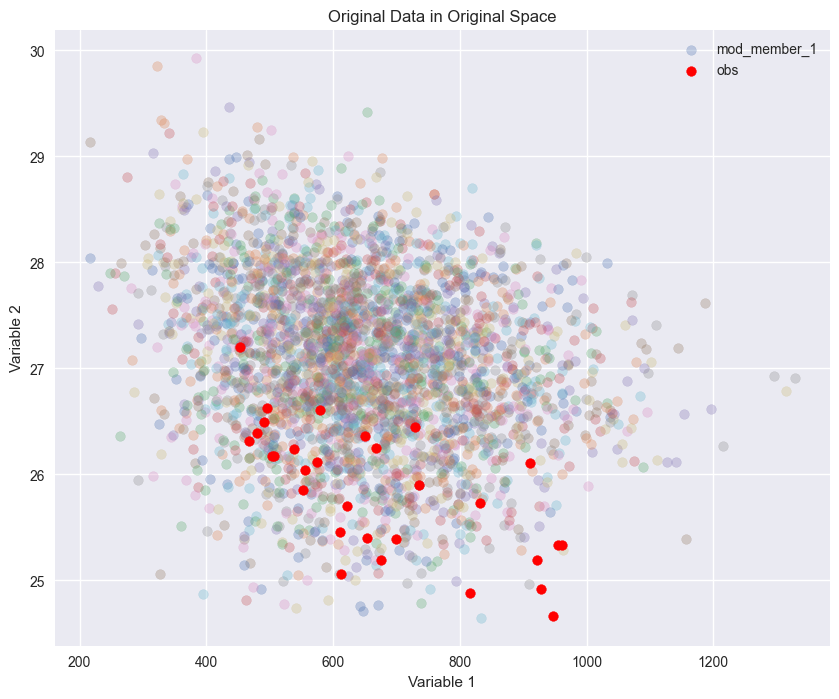

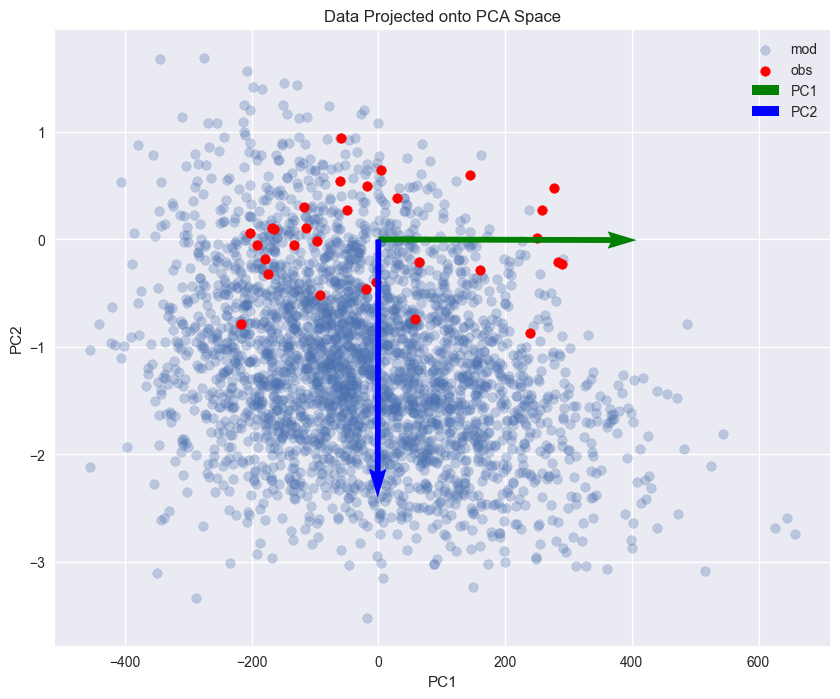

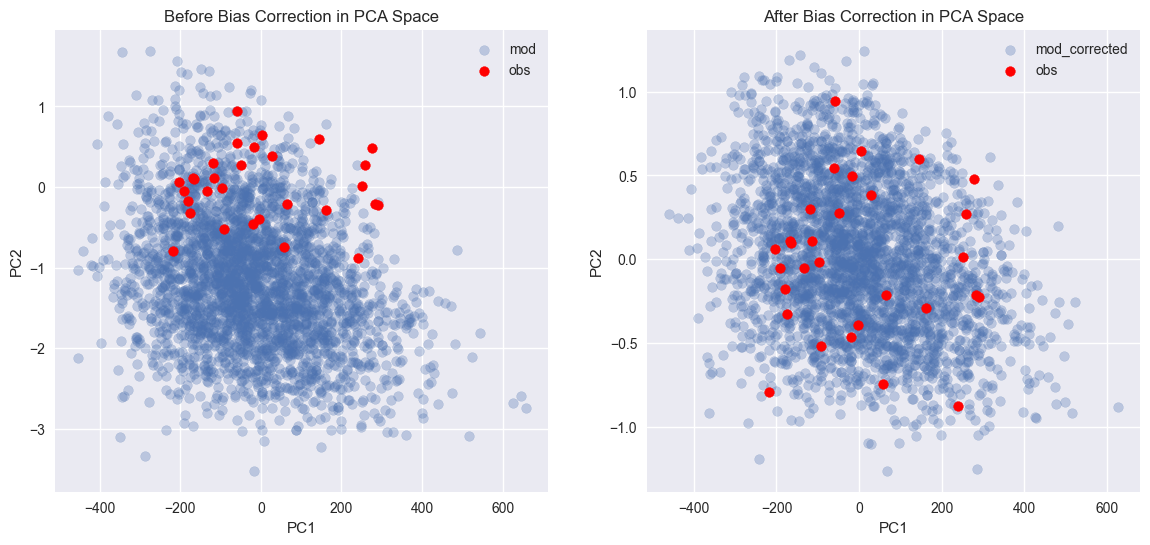

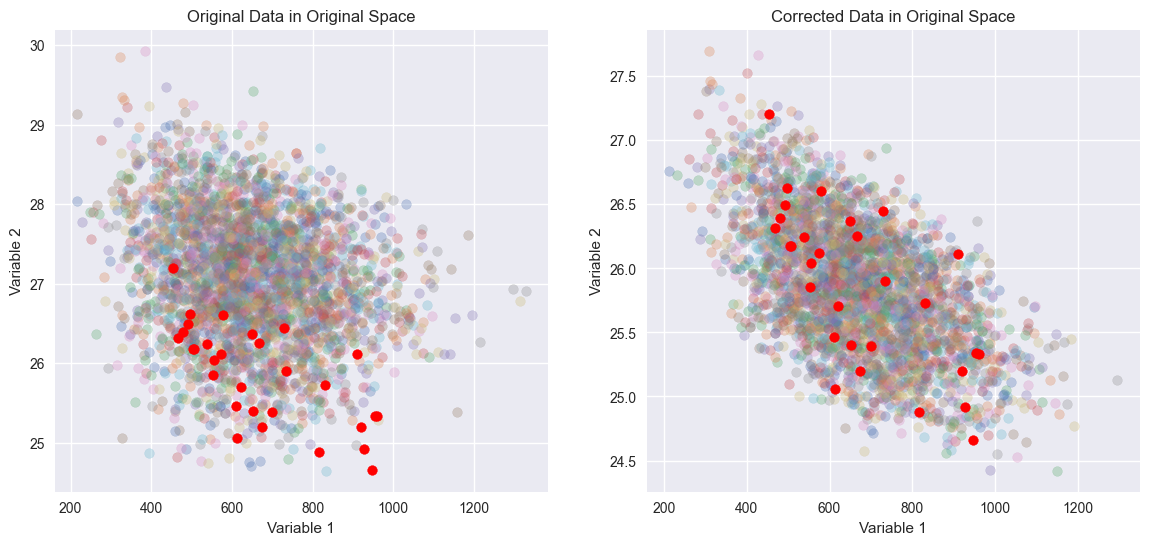

In [45]:
# Visualize Original Data in Original Space
def plot_original_data(mod, obs):
    plt.figure(figsize=(10, 8))
    for i in range(100):
        plt.scatter(mod[:, i, 0], mod[:, i, 1], alpha=0.3, label=f'mod_member_{i+1}' if i == 0 else "")
    plt.scatter(obs[:, 0], obs[:, 1], color='r', label='obs')
    plt.title("Original Data in Original Space")
    plt.legend()
    plt.xlabel("Variable 1")
    plt.ylabel("Variable 2")
    plt.show()

# Step 2: PCA Fit and Transform
pca = PCA(n_components=2)
pca.fit(obs_combined)
mod_pca = np.array([pca.transform(mod_raw[:, i, :]) for i in range(100)]).reshape(-1, 2)
obs_pca = pca.transform(obs_combined)

def plot_pca_space(mod_pca, obs_pca, eigenvectors):
    plt.figure(figsize=(10, 8))
    plt.scatter(mod_pca[:, 0], mod_pca[:, 1], alpha=0.3, label='mod')
    plt.scatter(obs_pca[:, 0], obs_pca[:, 1], color='r', label='obs')
    origin = np.zeros(2)
    plt.quiver(*origin, *eigenvectors[:, 0], color='g', scale=3, label='PC1')
    plt.quiver(*origin, *eigenvectors[:, 1], color='b', scale=3, label='PC2')
    plt.title("Data Projected onto PCA Space")
    plt.legend()
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.show()

# Step 3: Plot Before and After Bias Correction in PCA Space
def plot_pca_before_after(mod_pca, obs_pca, mod_pca_corrected):
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.scatter(mod_pca[:, 0], mod_pca[:, 1], alpha=0.3, label='mod')
    plt.scatter(obs_pca[:, 0], obs_pca[:, 1], color='r', label='obs')
    plt.title("Before Bias Correction in PCA Space")
    plt.legend()
    plt.xlabel("PC1")
    plt.ylabel("PC2")

    plt.subplot(1, 2, 2)
    plt.scatter(mod_pca_corrected[:, 0], mod_pca_corrected[:, 1], alpha=0.3, label='mod_corrected')
    plt.scatter(obs_pca[:, 0], obs_pca[:, 1], color='r', label='obs')
    plt.title("After Bias Correction in PCA Space")
    plt.legend()
    plt.xlabel("PC1")
    plt.ylabel("PC2")

    plt.show()

# Step 4: Plot Original Data vs Corrected Data in Original Space
def plot_corrected_data(mod, mod_corrected, obs):
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    for i in range(100):
        plt.scatter(mod[:, i, 0], mod[:, i, 1], alpha=0.3)
    plt.scatter(obs[:, 0], obs[:, 1], color='r', label='obs')
    plt.title("Original Data in Original Space")
    plt.xlabel("Variable 1")
    plt.ylabel("Variable 2")

    plt.subplot(1, 2, 2)
    for i in range(100):
        plt.scatter(mod_corrected[:, i, 0], mod_corrected[:, i, 1], alpha=0.3)
    plt.scatter(obs[:, 0], obs[:, 1], color='r', label='obs')
    plt.title("Corrected Data in Original Space")
    plt.xlabel("Variable 1")
    plt.ylabel("Variable 2")

    plt.show()


def pca_bias_variance_correction_manual(mod, obs):
    n_years, n_ensembles, n_vars = mod.shape    
    # Reshape for PCA
    mod_reshaped = mod.reshape(-1, n_vars)   
    # Center the observation data
    X_mean = np.mean(obs, axis=0)
    X_centered = obs - X_mean
    # Calculate covariance matrix
    cov_matrix = np.cov(X_centered, rowvar=False)
    # Eigenvalue decomposition
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
    # Sort eigenvalues and eigenvectors
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues_sorted = eigenvalues[sorted_indices]
    eigenvectors_sorted = eigenvectors[:, sorted_indices]
    W = eigenvectors_sorted[:, :2]
    # Project observation data onto PCA space
    obs_pca = np.dot(X_centered, W)    
    # Calculate means and std deviations in PCA space for observations
    obs_mean_pca = np.mean(obs_pca, axis=0)
    obs_std_pca = np.std(obs_pca, axis=0)   
    # Prepare corrected model data
    mod_corrected = np.zeros_like(mod)    
    for i in range(n_ensembles):
        # Center the model data
        mod_member = mod[:, i, :]
        mod_mean = np.mean(mod_member, axis=0)
        mod_member_centered = mod_member - mod_mean        
        # Project model data onto PCA space
        mod_member_pca = np.dot(mod_member_centered, W)        
        # Calculate means and std deviations in PCA space for model data
        mod_mean_pca = np.mean(mod_member_pca, axis=0)
        mod_std_pca = np.std(mod_member_pca, axis=0)        
        # Bias and variance correction in PCA space
        mod_member_pca_corrected = ((mod_member_pca - mod_mean_pca) / mod_std_pca) * obs_std_pca + obs_mean_pca        
        # Inverse transform to original space
        mod_member_corrected_centered = np.dot(mod_member_pca_corrected, W.T)
        mod_member_corrected = mod_member_corrected_centered + mod_mean       
        mod_corrected[:, i, :] = mod_member_corrected    
    return mod_corrected



plot_original_data(mod_raw, obs_combined)
# Visualize Data in PCA Space with Eigenvectors
eigenvectors = pca.components_.T
plot_pca_space(mod_pca, obs_pca, eigenvectors)
mod_corrected = pca_bias_variance_correction_modified(mod_raw, obs_combined)
# Visualize Before and After Bias Correction in PCA Space
mod_pca_corrected = np.array([pca.transform(mod_corrected[:, i, :]) for i in range(100)]).reshape(-1, 2)
plot_pca_before_after(mod_pca, obs_pca, mod_pca_corrected)
# Step 4: Visualize Original Data vs Corrected Data in Original Space
plot_corrected_data(mod_raw, mod_corrected, obs_combined)
